In [1]:
!pip install pandas transformers accelerate


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import re
from io import StringIO

import pandas as pd
import torch
from PIL import Image
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration

MODEL = "Qwen/Qwen2.5-VL-7B-Instruct"  # 画像入力対応の公開重み

In [3]:
device_map = "auto"  # CUDA/MPS/CPU 自動
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

processor = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    MODEL, torch_dtype=torch_dtype, device_map=device_map, trust_remote_code=True
)
model.eval()

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): Qwen2_5_VLMLP(
            (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
            (act_fn): SiLU()

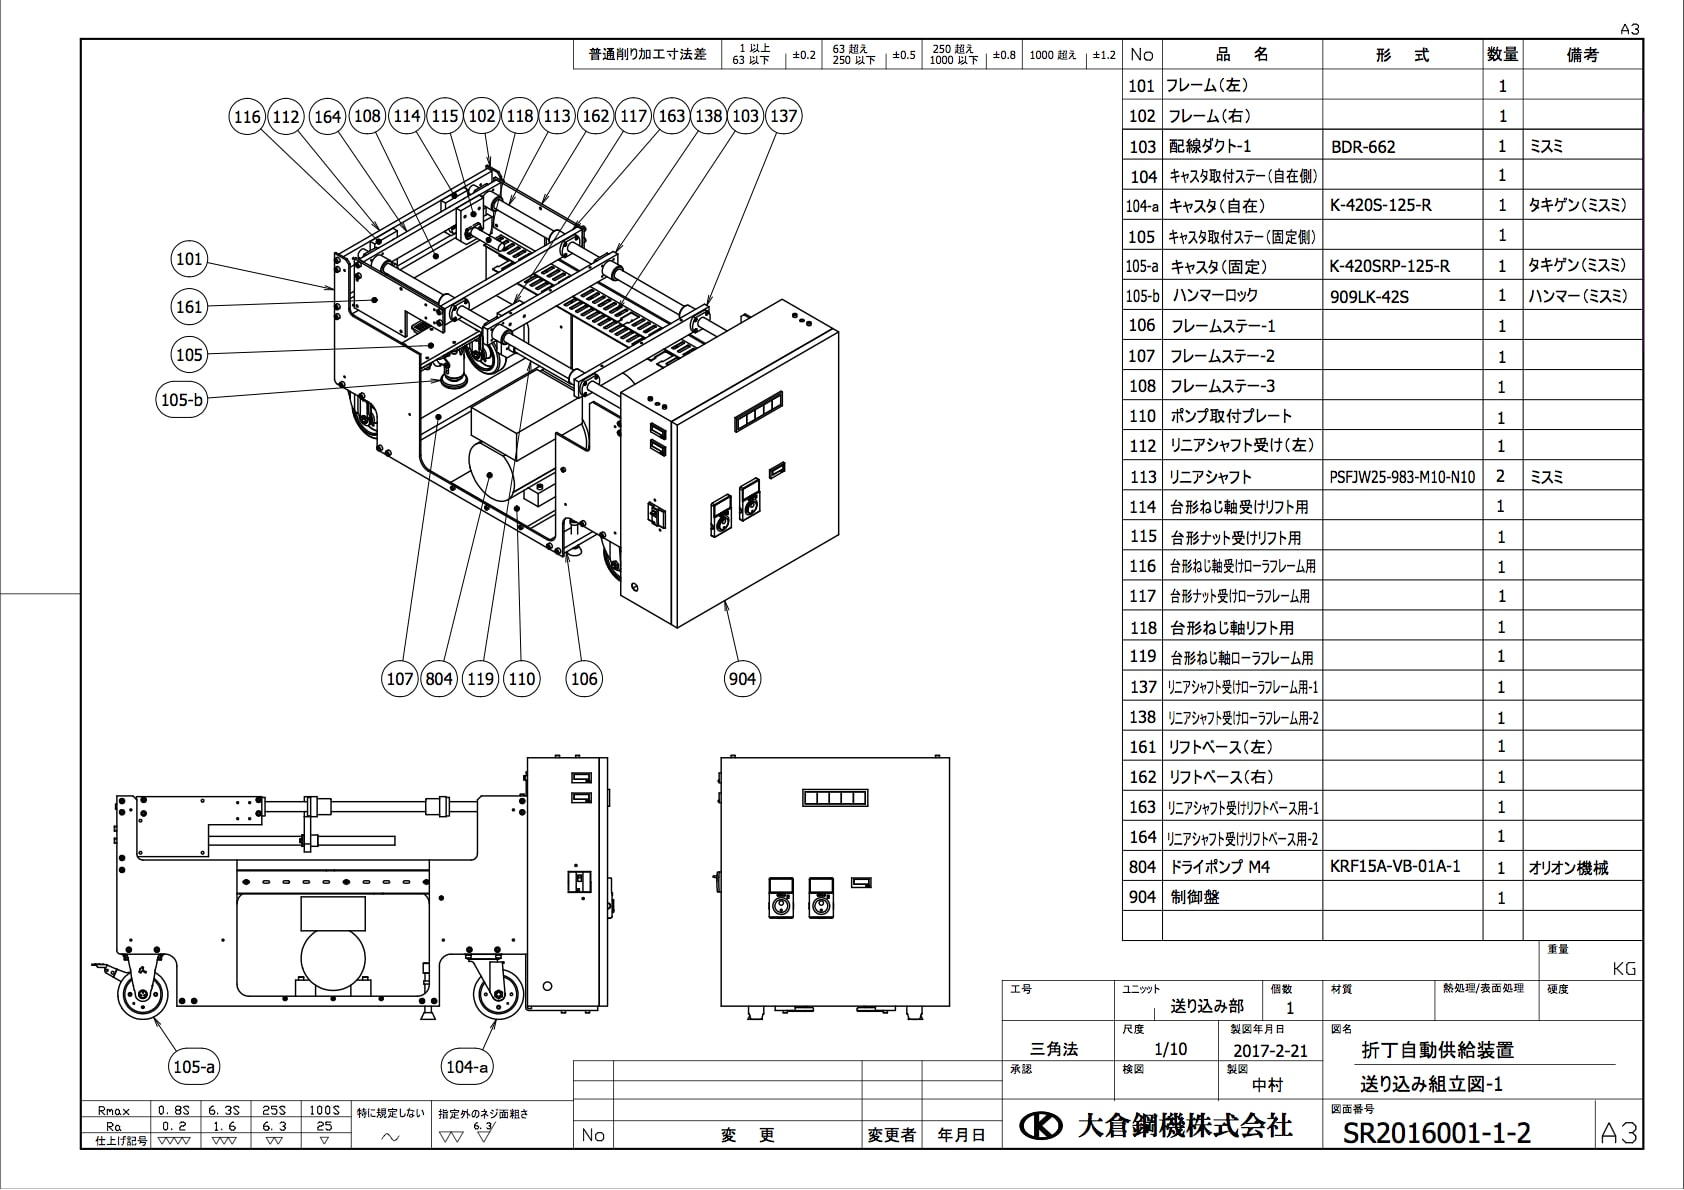

In [4]:
img = Image.open("./images/test.jpg").convert("RGB")
display(img)

In [20]:
prompt0 = (
    "あなたは、機械設計のスペシャリストです。"
    "この画像がどういうものか説明しなさい。"
)
print(prompt0)

あなたは、機械設計のスペシャリストです。この画像がどういうものか説明しなさい。


In [21]:
import time

# Qwenのチャットテンプレート：<image>トークンを含む形式
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": img},
            {"type": "text", "text": prompt0},
        ],
    },
]
inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device)

start = time.time()
with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=2500,
        do_sample=False,
        temperature=0,
    )
end = time.time()

print(f"Inference Time: {end - start}")

# Decode only the generated tokens (excluding the input)
generated_ids = [output_ids[i][len(inputs.input_ids[i]) :] for i in range(len(output_ids))]
text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
print(text)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Inference Time: 15.22184419631958
この画像は機械設計の図面であり、折丁自動供給装置の組立図を示しています。以下に詳細を説明します：

1. **主な部品のリスト**：
   - この図面には、折丁自動供給装置の主要な部品がリストされています。各部品には番号が付けられており、右側の表でその番号に対応する部品名と形式、数量、備考が記載されています。

2. **部品の詳細**：
   - 各部品の詳細情報は、右側の表で提供されています。例えば、フレーム（左）やフレーム（右）、配線ダクト、キャスタ取付ステーなどがあります。
   - 一部の部品には、特定の製造会社や型番が記載されており、例えば「K-420S-125-R」や「909LK-42S」などがあります。

3. **寸法と仕様**：
   - 左下の部分には、各部品の寸法や仕様が記載されています。例えば、Rmax（最大半径）やRa（表面粗さ）などの値が示されています。

4. **図面の詳細**：
   - 中央の図面には、折丁自動供給装置の全体的な構造が描かれています。各部品がどのように配置されているかが視覚的に理解できます。
   - 下部には、部品の配置図も示されており、より具体的な位置関係を確認できます。

5. **製造情報**：
   - 右下の部分には、製造会社（大倉鋼機株式会社）と製造年月日（2017年2月21日）が記載されています。

この図面は、機械設計者が部品の配置や寸法を確認し、製造時に必要な情報を提供するために使用されます。また、保守や修理の際にも役立ちます。


In [22]:
prompt1 = (
    "あなたは、機械設計のスペシャリストです。"
    "この画像がどういうものか把握し、JSONで厳密に定義しなさい。"
)
print(prompt1)

あなたは、機械設計のスペシャリストです。この画像がどういうものか把握し、JSONで厳密に定義しなさい。


In [23]:
import time

# Qwenのチャットテンプレート：<image>トークンを含む形式
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": img},
            {"type": "text", "text": prompt1},
        ],
    },
]
inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device)

start = time.time()
with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=2500,
        do_sample=False,
        temperature=0,
    )
end = time.time()

print(f"Inference Time: {end - start}")

# Decode only the generated tokens (excluding the input)
generated_ids = [output_ids[i][len(inputs.input_ids[i]) :] for i in range(len(output_ids))]
text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
print(text)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Inference Time: 50.72851371765137
```json
{
  "type": "機械設計図",
  "scale": "A3",
  "製造年月日": "2017-2-21",
  "製図者": "中村",
  "機械名": "折丁自動供給装置",
  "部品一覧": {
    "101": {
      "品名": "フレーム（左）",
      "形式": "",
      "数量": 1,
      "備考": ""
    },
    "102": {
      "品名": "フレーム（右）",
      "形式": "",
      "数量": 1,
      "備考": ""
    },
    "103": {
      "品名": "配線ダクト-1",
      "形式": "BDR-662",
      "数量": 1,
      "備考": "ミスミ"
    },
    "104": {
      "品名": "キャスタ取付ステー（自在側）",
      "形式": "",
      "数量": 1,
      "備考": ""
    },
    "104-a": {
      "品名": "キャスタ（自在）",
      "形式": "K-420S-125-R",
      "数量": 1,
      "備考": "タキゲン（ミスミ）"
    },
    "105": {
      "品名": "キャスタ取付ステー（固定側）",
      "形式": "",
      "数量": 1,
      "備考": ""
    },
    "105-a": {
      "品名": "キャスタ（固定）",
      "形式": "K-420SRP-125-R",
      "数量": 1,
      "備考": "タキゲン（ミスミ）"
    },
    "105-b": {
      "品名": "ハンマーロック",
      "形式": "909LK-42S",
      "数量": 1,
      "備考": "ハンマー（ミスミ）"
    },
    "106": {
      "品名": "フレームステー-1",
    

In [24]:
prompt2 = (
    "あなたは、機械設計のスペシャリストです。"
    "この画像の中の表形式のデータを抽出し、JSONで厳密に出力しなさい。"
    "説明文・コードフェンスは禁止。要素数は各行で一致させること。"
    "空欄は''とし、英数字は半角とすること。"
)
print(prompt2)

あなたは、機械設計のスペシャリストです。この画像の中の表形式のデータを抽出し、JSONで厳密に出力しなさい。説明文・コードフェンスは禁止。要素数は各行で一致させること。空欄は''とし、英数字は半角とすること。


In [25]:
import time

# Qwenのチャットテンプレート：<image>トークンを含む形式
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": img},
            {"type": "text", "text": prompt2},
        ],
    },
]
inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device)

start = time.time()
with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=2500,
        do_sample=False,
        temperature=0,
    )
end = time.time()

print(f"Inference Time: {end - start}")

# Decode only the generated tokens (excluding the input)
generated_ids = [output_ids[i][len(inputs.input_ids[i]) :] for i in range(len(output_ids))]
text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
print(text)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Inference Time: 45.62405705451965
```json
[
    {
        "No": "101",
        "品名": "フレーム（左）",
        "形式": "",
        "数量": "1",
        "備考": ""
    },
    {
        "No": "102",
        "品名": "フレーム（右）",
        "形式": "",
        "数量": "1",
        "備考": ""
    },
    {
        "No": "103",
        "品名": "配線ダクト-1",
        "形式": "BDR-662",
        "数量": "1",
        "備考": "ミスミ"
    },
    {
        "No": "104",
        "品名": "キャスタ取付ステー（自在側）",
        "形式": "",
        "数量": "1",
        "備考": ""
    },
    {
        "No": "104-a",
        "品名": "キャスタ（自在）",
        "形式": "K-420S-125-R",
        "数量": "1",
        "備考": "タキゲン（ミスミ）"
    },
    {
        "No": "105",
        "品名": "キャスタ取付ステー（固定側）",
        "形式": "",
        "数量": "1",
        "備考": ""
    },
    {
        "No": "105-a",
        "品名": "キャスタ（固定）",
        "形式": "K-420SRP-125-R",
        "数量": "1",
        "備考": "タキゲン（ミスミ）"
    },
    {
        "No": "105-b",
        "品名": "ハンマーロック",
        "形式": "909LK-42S",
        "数

In [26]:
# # CSVだけを抽出
# # Remove any leading text before the CSV data starts
# lines = text.strip().split("\n")
# csv_lines = []
# csv_started = False

# for line in lines:
#     # Check if line looks like CSV (contains commas or is a header)
#     if not csv_started and "," in line:
#         csv_started = True
#     if csv_started:
#         # Skip code fence markers if present
#         if not line.startswith("```"):
#             csv_lines.append(line)
#
# csv_text = "\n".join(csv_lines)
#
# # 読めるか検証
# try:
#     if csv_text:
#         df = pd.read_csv(StringIO(csv_text))
#         print("Successfully parsed CSV:")
#         print(df.head())
#         print(f"\nShape: {df.shape}")
#         df.to_csv("extracted_table.csv", index=False)
#         print("Saved to extracted_table.csv")
#     else:
#         print("No CSV data found in the output")
#         print("Raw output:", text[:1000])
# except Exception as e:
#     print(f"CSV parse failed: {e}")
#     print("Raw CSV text:\n", csv_text[:1000])
#     raise